In [1]:
from arpes.io import load_data
from arpes.utilities.conversion import convert_to_kspace

import os.path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import math
import numpy as np
import xarray as xr
import fft_PSI


C:\Users\fb7365\Documents\CODES\arpes\arpes\config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2023-10-27_19-27-31.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
# Define directory
path = os.path.abspath("E:/DATA/EPFL/ARPES/e19775/Box_1_square_renamed")

# Different parameters used to set up scans at SLS
scan_type = 'FS'
direction = 'N'
phi = '*'
energy = '*'
polarization = '*'
temp = '*'
e_pass = '*'+'eVpass'
comment = ''
run = '*'.zfill(4)

# Put together string for finding file
parameters = [scan_type, direction, phi, energy, polarization, temp, e_pass, comment, run]
if comment == '':
    parameters.remove(comment)
file_type = 'h5'
file_name = '_'.join(parameters)
file = '.'.join([file_name , file_type])

full_file = os.path.join(path, file)
file

'FS_N_*_*_*_*_*eVpass_000*.h5'

In [3]:
import glob
# Load all files with above specified parameters, * is a placeholder and imports all files in its place
files = glob.glob(full_file)
print('Files found: '+str(len(files)))


Files found: 15


In [4]:
data_list = {}
for file in files:
    #data_list.append(load_data(file, location="ULTRA"))
    # data = load_data(file, location="ULTRA")
    file_name = file.replace(path, '')[1:-3]
    data_list.update({file_name : '0'})

In [5]:
#! Plot section

# rows = math.ceil(len(data_list) / 2)
# fig, ax = plt.subplots(rows, 2, figsize=(14, 6*rows))
# fig.suptitle('Overview of Bi2223 FS 1. Beamtime', fontsize=20)
# for key in data_list.keys():
#     data = data_list[key].spectrum
#     fs = data.sel(eV=slice(-0.02,0.02)).sum("eV")
#     fs.plot(ax=ax.ravel()[list(data_list).index(key)])
#     ax.ravel()[list(data_list).index(key)].set_title(f"{key}")
#     plt.tight_layout(rect=[0, 0.03, 1, 0.98])

In [6]:
# correct for Fermi level from Gold samples

folder_box1 = 'E:/DATA/EPFL/ARPES/e19775/Box_1_square/'
file_box1_square = os.listdir(folder_box1)

gold_ref = [s for s in file_box1_square if 'Gold' in s ] +[s for s in file_box1_square if 'GOLD' in s ]
gold_ref = [s for s in gold_ref if not('._') in s]
    
gold_list = {}
for file in gold_ref:
    #data_list.append(load_data(file, location="ULTRA"))
    data = load_data(folder_box1+file, location="ULTRA")
    scan_name = file.replace('.h5', '')
    gold_list.update({scan_name : data})
    
    

In [7]:
#! Plot section Gold EDC

# rows = math.ceil(len(data_list) / 2)
# fig, ax = plt.subplots(rows, 2, figsize=(14, 6*rows))
# fig.suptitle('Overview of gold Fermi level  1st beamtime', fontsize=20)
# for key in gold_list.keys():
#     data = gold_list[key]
# #     fs.plot(ax=ax.ravel()[list(gold_list).index(key)])
#     data.spectrum.T.plot(ax=ax.ravel()[list(gold_list).index(key)])
#     ax.ravel()[list(gold_list).index(key)].set_title(f"{key}")
#     plt.tight_layout(rect=[0, 0.03, 1, 0.98])

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/52 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


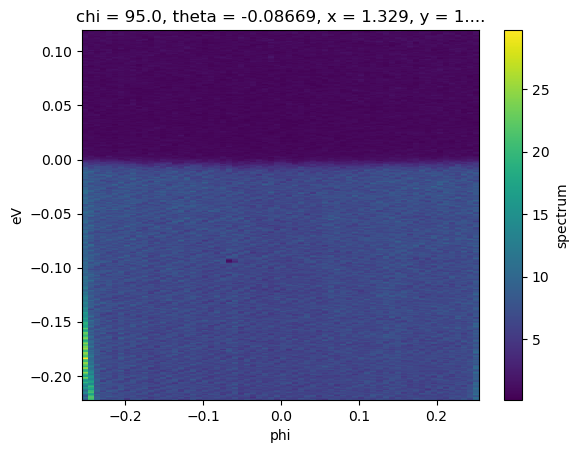

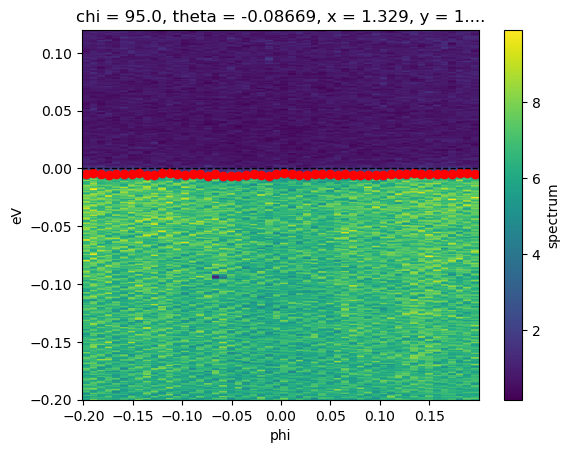

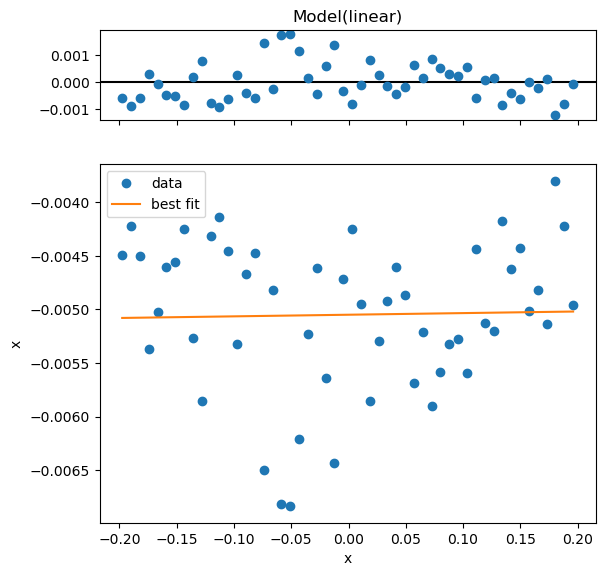

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/52 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


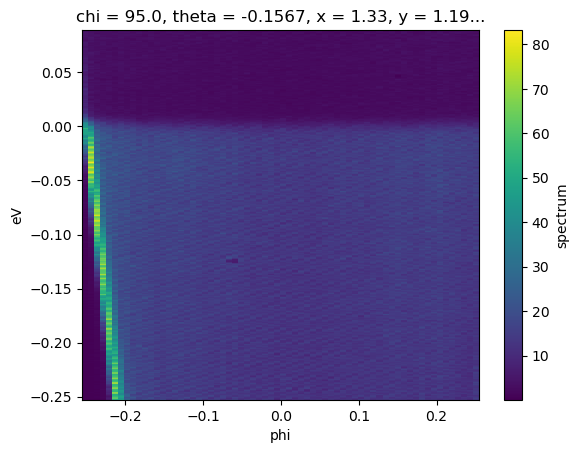

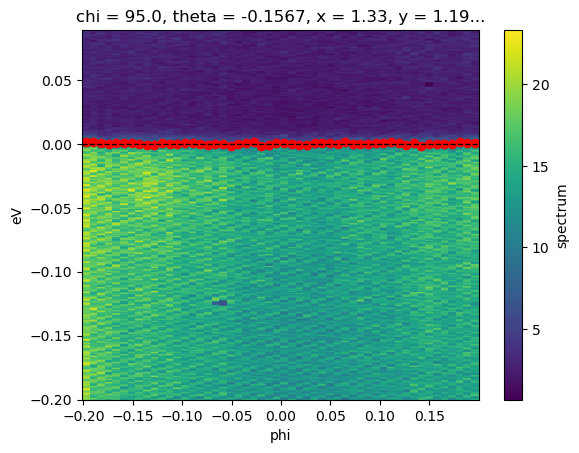

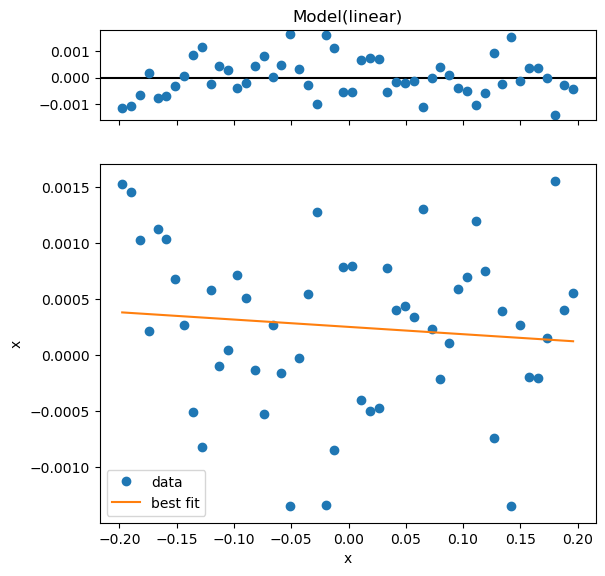

In [8]:
from arpes.analysis.general import rebin
from arpes.all import AffineBroadenedFD, broadcast_model, LinearModel

data_gold = {}
data_gold['LT'] = {} 
data_gold['HT'] = {} 
data_gold['LT']['data'] = gold_list['EDC_Gold_sample1_11K_5eV pass_26p5_0002']
data_gold['HT']['data'] = gold_list['EDC_GOLD_REF_11K_5eVpass_52eV_CIRCP_0000']

for temperature in data_gold:

    binned = rebin(data_gold[temperature]['data'], phi=10).spectrum
    fig, ax = plt.subplots()

    binned.plot(ax= ax)

    fermi_level = binned.sel(phi=slice(-0.2,0.2), eV=slice(-0.2,0.2))
    fig, ax = plt.subplots()

    fermi_level.plot(ax= ax)
    if temperature == 'HT':
        results = broadcast_model(AffineBroadenedFD, fermi_level, "phi", params={"fd_center": {"value": 0.001},
                                                         "fd_width": {"value": 0.003},
                                                         "lin_bkg" :  {"value": 200}, 
                                                         "const_bkg" :  {"value": 8e2},
                                                         "offset" :  {"value": 1e2},
                                                         })
    else:
        results = broadcast_model(AffineBroadenedFD, fermi_level, "phi")   

    ax.scatter(*results.F.p("fd_center").G.to_arrays(), color="red")
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1)

    lin_mod = LinearModel().guess_fit(results.F.p("fd_center"))
    lin_mod.plot()
    data_gold[temperature]['fit_Fermi'] = lin_mod

    plt.show()

    results.F.show()

In [9]:
name_scans = list(data_list.keys())
print(name_scans)

good_scans = ['FS_N_P50_26p5eV_CIRCM_LT_10eVpass_0000',
              'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0002', 
              'FS_N_P50_26p5eV_CIRCP_HT_10eVpass_0003']
angle_offsets = {}
angle_offsets["Bi2223"] = {
    "phi": 0.075,    # controls the offset along the analyzer center axis
    "theta": 0,
    "chi": 49.999125,    # sample rotation, controls kx-ky plane orientation
    "alpha": 0,
    "beta": -0.04,
}


['FS_N_M42_26p5eV_LHQ_LT_5eVpass_0001', 'FS_N_P50_26p5eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCP_HT_10eVpass_0003', 'FS_N_P50_52eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_52eV_LVLE_LT_10eVpass_0000', 'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0000', 'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0001', 'FS_N_M42_26p5eV_LHQ_LT_5eVpass_0000', 'FS_N_M43_25eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCP_HT_10eVpass_0000', 'FS_N_M43_26p5eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCM_LT_10eVpass_0000', 'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0002', 'FS_N_P50_26p5eV_CIRCP_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCM_LT_10eVpass_0001']


In [10]:
bi2223_data_list = {}
for file in [good_scans[0]]:
    raw_data = load_data(path+ os.sep+ file+'.h5', location="ULTRA")
    if 'LT' in file:
        edge = data_gold['LT']['fit_Fermi'].eval(x=raw_data.spectrum.phi)
    elif 'HT' in file:
        edge = data_gold['HT']['fit_Fermi'].eval(x=raw_data.spectrum.phi)
    else:
        print('Error: find Fermi level')
    edge_xr = xr.DataArray(edge, coords={'phi': raw_data.phi}, dims=["phi"])

    corrected_data = raw_data.spectrum.G.shift_by(edge_xr, shift_axis="eV")
    
    corrected_data.S.apply_offsets(angle_offsets["Bi2223"])
    dims = ['beta']
    filtered_set = corrected_data.copy()
    dimension = corrected_data[dims[0]]

    for i, d in enumerate(dimension):
        filtered_set.data[:,:,i] = fft_PSI.fourier_filter_2d(corrected_data.sel({dimension.name:d}).data)
    del corrected_data

    k_data = convert_to_kspace(filtered_set, 
                                kx=np.linspace(-1, 1, 200),
                                ky=np.linspace(-1, 1, 200))
    file_name = file
    bi2223_data_list.update({file_name : k_data})
    

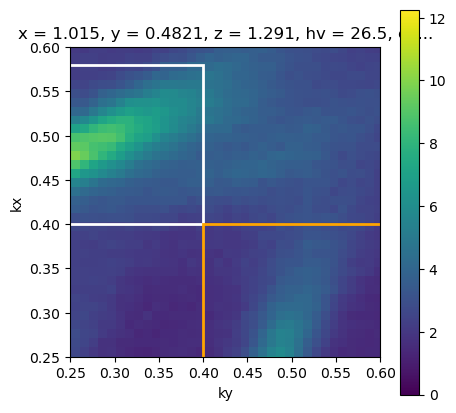

In [11]:

scan = bi2223_data_list[good_scans[0]]


# corrected_data.S.fermi_surface.plot(ax = ax)
# fig, ax = plt.subplots()
# scan.S.fermi_surface.plot(ax = ax)
# rect_b = patches.Rectangle((-0.4, -0.58), 0.8, 0.18, linewidth=2, edgecolor='r', facecolor='none')
# rect_t = patches.Rectangle((-0.4, 0.4), 0.8, 0.18, linewidth=2, edgecolor='w', facecolor='none')
# rect_l = patches.Rectangle((-0.58, -0.4), 0.18, 0.8, linewidth=2, edgecolor='k', facecolor='none')
# rect_r = patches.Rectangle((0.4, -0.4), 0.22, 0.8, linewidth=2, edgecolor='orange', facecolor='none')


fig, ax = plt.subplots(figsize = (5,5))

scan.S.fermi_surface.plot(ax = ax)

rect_b = patches.Rectangle((-0.4, -0.58), 0.8, 0.18, linewidth=2, edgecolor='r', facecolor='none')
rect_t = patches.Rectangle((-0.4, 0.4), 0.8, 0.18, linewidth=2, edgecolor='w', facecolor='none')
rect_l = patches.Rectangle((-0.58, -0.4), 0.18, 0.8, linewidth=2, edgecolor='k', facecolor='none')
rect_r = patches.Rectangle((0.4, -0.4), 0.22, 0.8, linewidth=2, edgecolor='orange', facecolor='none')
ax.add_patch(rect_b)
ax.add_patch(rect_t)
ax.add_patch(rect_l)
ax.add_patch(rect_r)
ax.axvline(0)
ax.axhline(0)

ax.set_xlim([-.8, 0.8])
ax.set_ylim([-.8, 0.8])

ax.set_xlim([.25, 0.6])
ax.set_ylim([0.25, 0.6])
ax.set_aspect('equal')
plt.show()

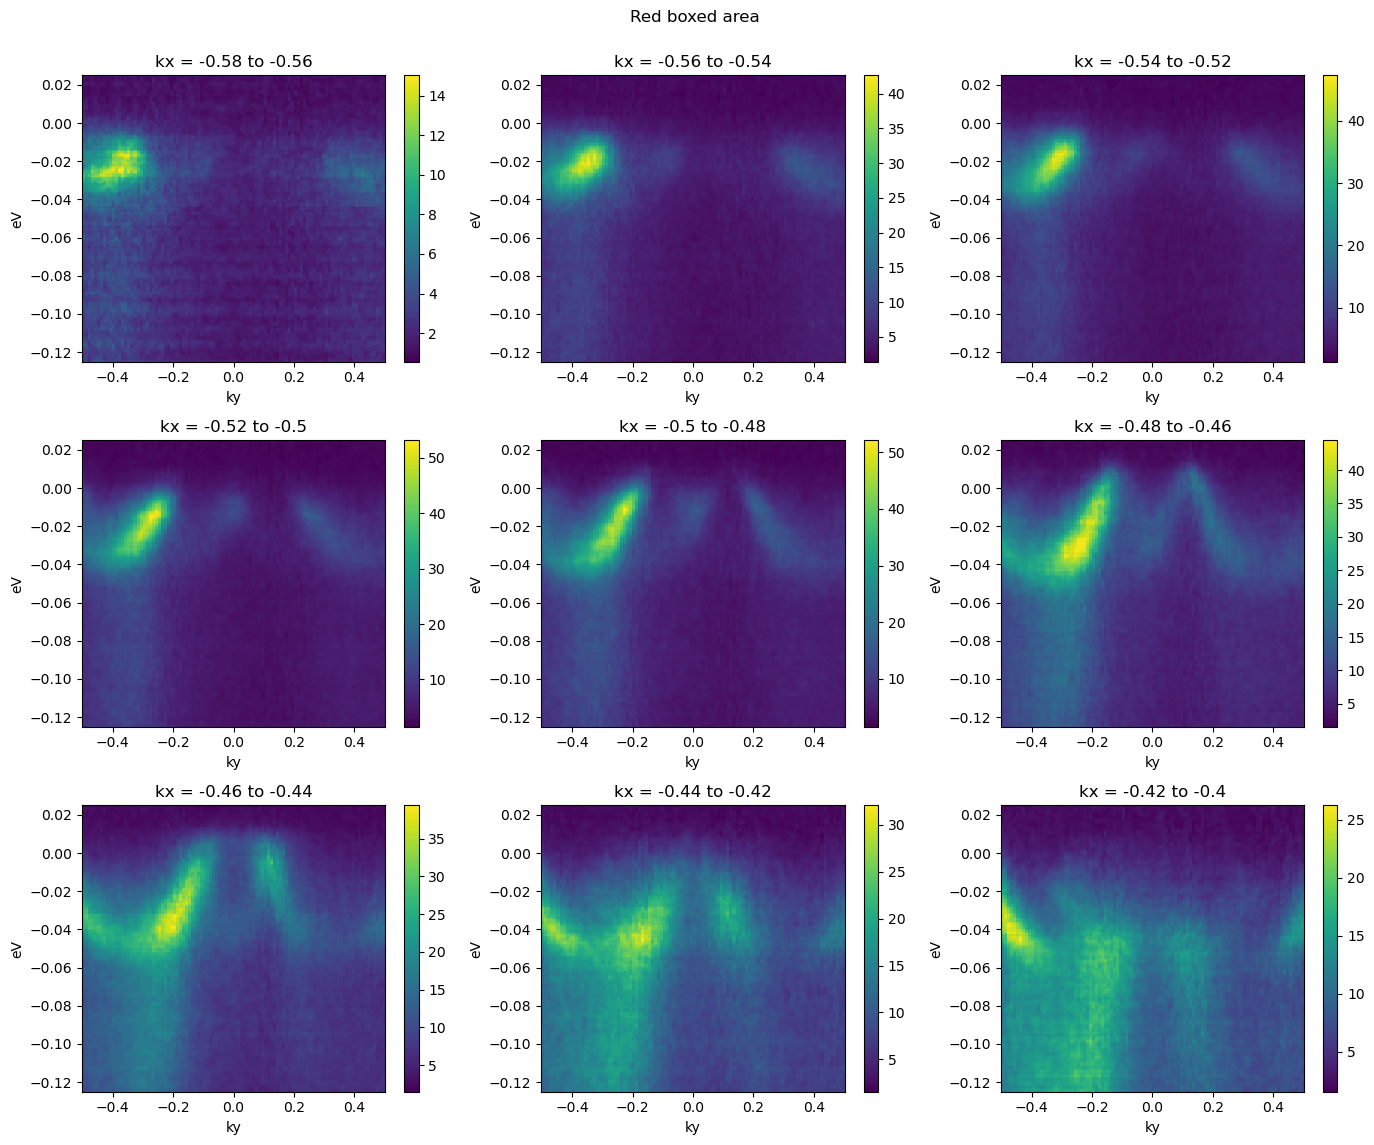

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
kx_list = np.arange(-0.58, -0.4, 0.02)
# kx_list = -np.arange(-0.58, -0.4, 0.02)

for i, kx_value in enumerate(kx_list):
    scan.sel(kx=slice(kx_value, kx_value+0.02), ky=slice(-0.5,0.5), eV=slice(-0.125, 0.025)).sum("kx").plot(ax=ax.ravel()[i])
    ax.ravel()[i].set_title(f"kx = {np.round(kx_value, 2)} to {np.round(kx_value+0.02, 2)}")

plt.suptitle('Red boxed area')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

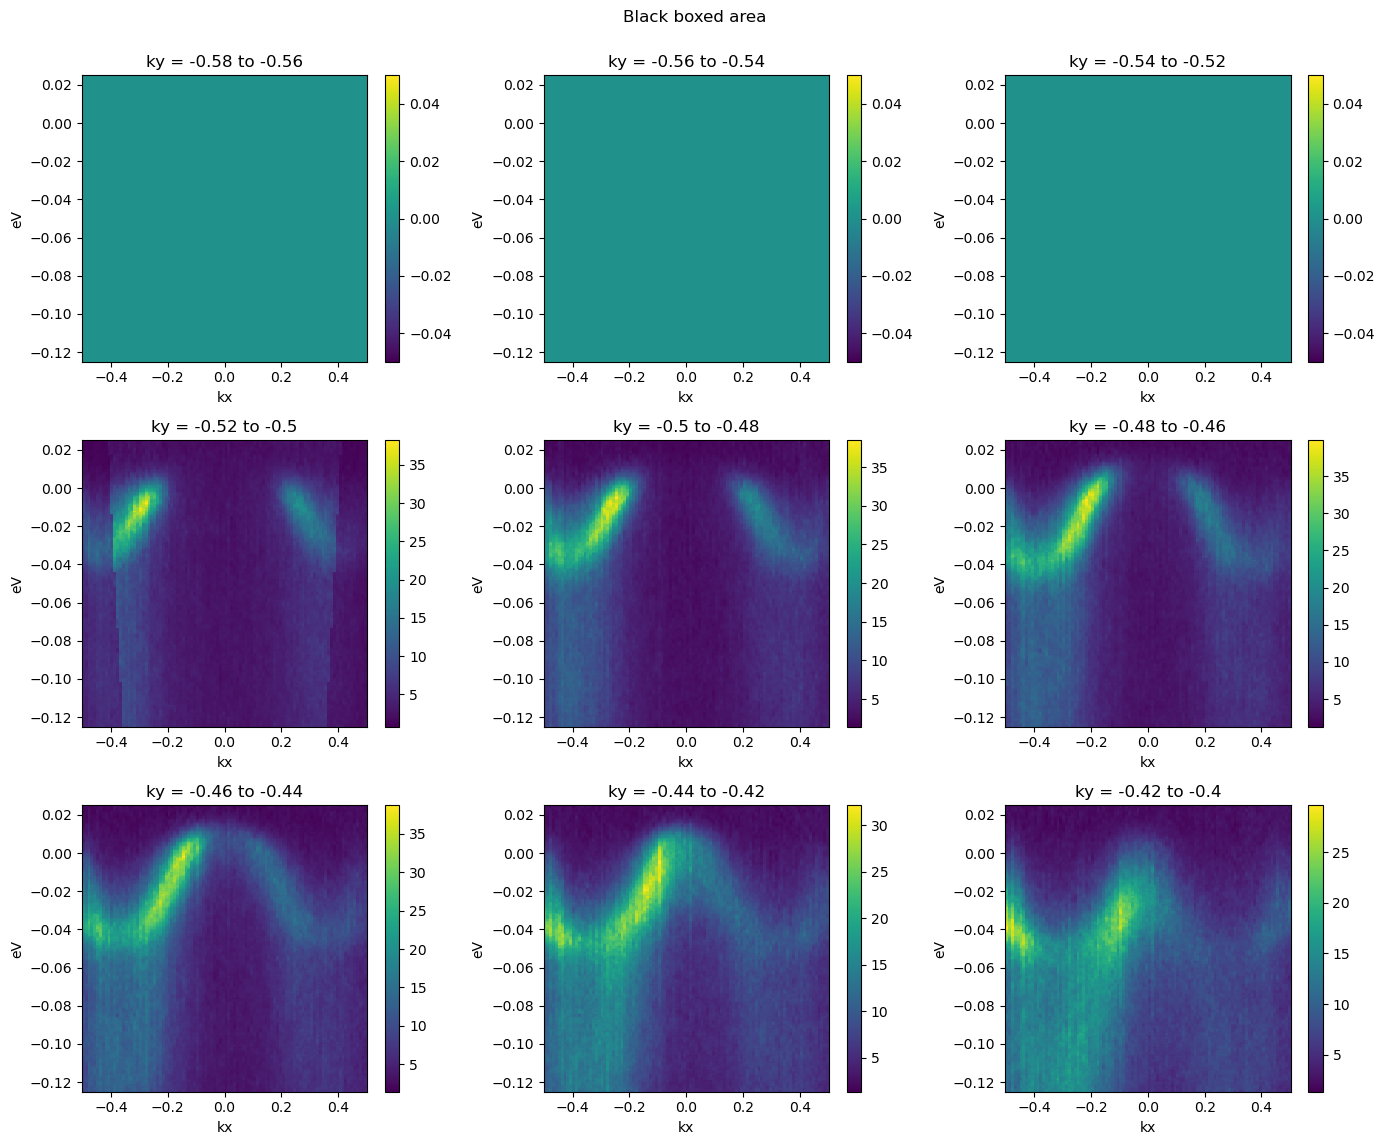

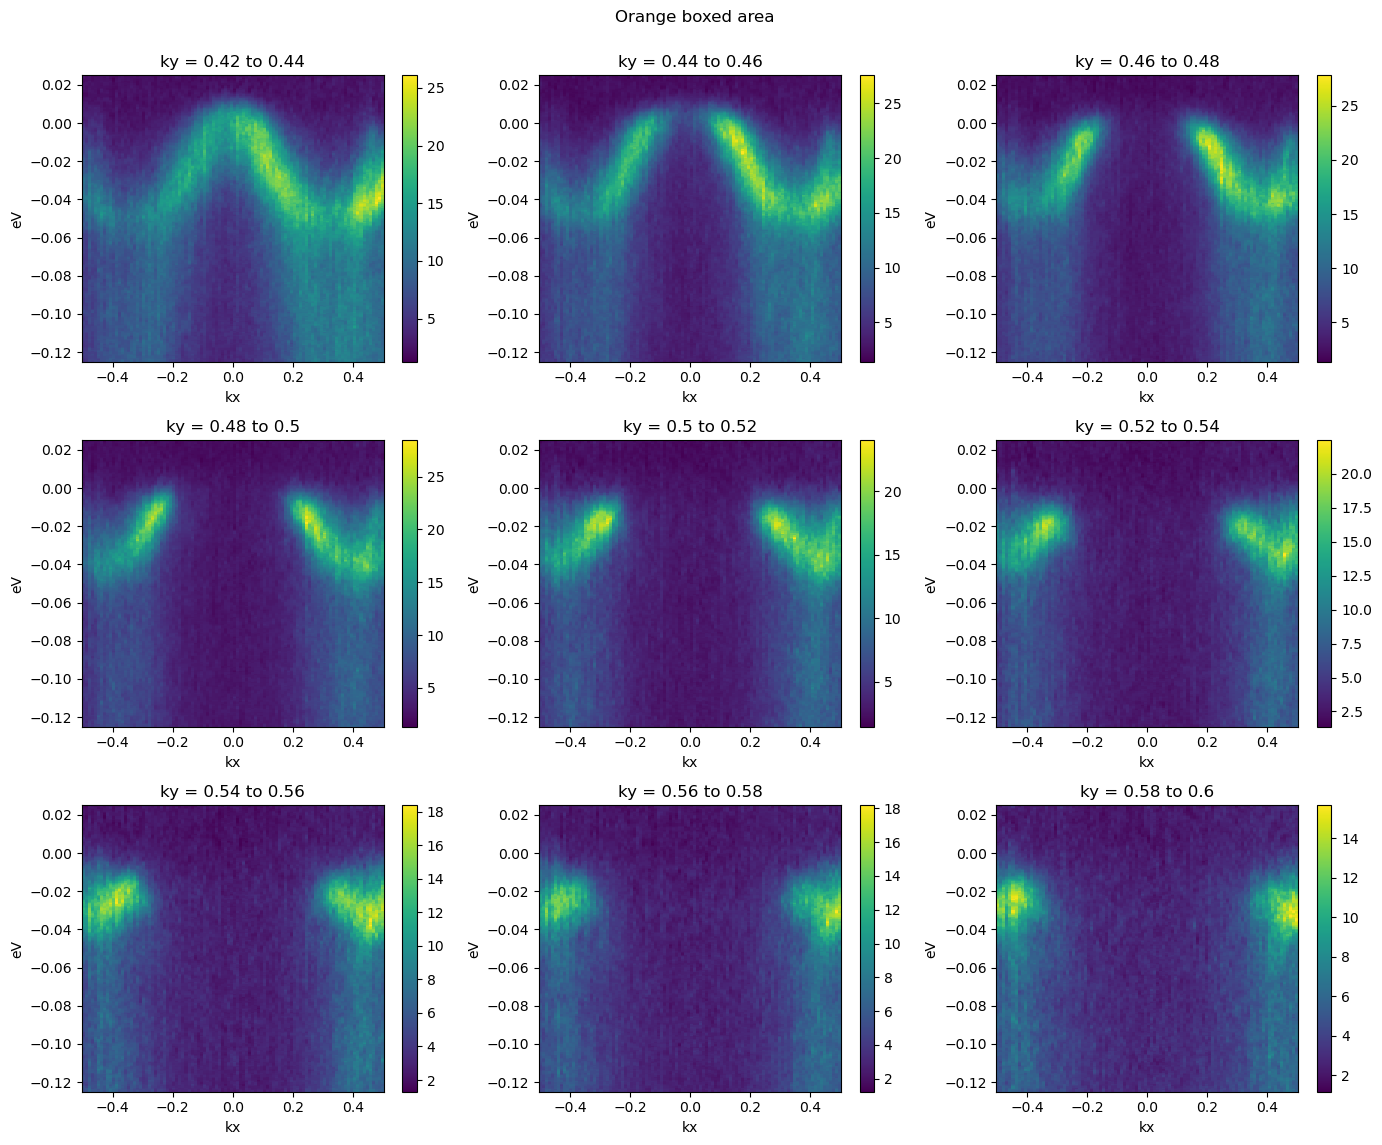

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
ky_list = np.arange(-0.58, -0.4, 0.02)
for i, ky_value in enumerate(ky_list):
    scan.sel(ky=slice(ky_value, ky_value+0.02), kx=slice(-0.5,0.5), eV=slice(-0.125, 0.025)).sum("ky").plot(ax=ax.ravel()[i])
    ax.ravel()[i].set_title(f"ky = {np.round(ky_value, 2)} to {np.round(ky_value+0.02, 2)}")

plt.suptitle('Black boxed area')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

fig, ax = plt.subplots(3, 3, figsize=(14, 12))
ky_list = -np.flip(np.arange(-0.58, -0.4, 0.02))
for i, ky_value in enumerate(ky_list):
    scan.sel(ky=slice(ky_value, ky_value+0.02), kx=slice(-0.5,0.5), eV=slice(-0.125, 0.025)).sum("ky").plot(ax=ax.ravel()[i])
    ax.ravel()[i].set_title(f"ky = {np.round(ky_value, 2)} to {np.round(ky_value+0.02, 2)}")

plt.suptitle('Orange boxed area')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

In [14]:
# import pprint # pretty print
# from arpes.utilities.bz import orthorhombic_cell, hex_cell_2d
# from arpes.plotting.bz import overplot_standard, bz_plot, plot_data_to_bz
# angle_offsets = {}
# angle_offsets["Bi2223"] = {
#     "phi": 0.,    # controls the offset along the analyzer center axis
#     "theta": 0.0,
#     "chi": 0,    # sample rotation, controls kx-ky plane orientation
#     "alpha": 0.,
#     "psi": 0.,
# }



# pprint.pprint(corrected_data.S.offsets)

# example_fs = corrected_data.S.fermi_surface.copy(deep=True)

# example_fs.S.apply_offsets(angle_offsets["Bi2223"] )
# k_data = convert_to_kspace(
#     example_fs
# )

# fig, ax = plt.subplots()
# # ax3d = fig.add_subplot(1,1,1, projection='3d')

# # bz_plot(cell=orthorhombic_cell(a=1,b=1, c=0.1), linewidth = 2, ax= ax, repeat = (2,2,1))


# plot_data_to_bz(k_data, orthorhombic_cell(a=1, b=1, c=1 ), ax = ax, rotate= np.deg2rad(15),
#                  scale = np.pi/3.85, shift = [0,0], bz_number = (0,0),)

# plot_data_to_bz(k_data, orthorhombic_cell(a=1, b=1, c=1 ), ax = ax, rotate= np.deg2rad(15),
#                  scale = np.pi/3.85, shift = [0,0], bz_number = (1,1),)
# plot_data_to_bz(k_data, orthorhombic_cell(a=1, b=1, c=1 ), ax = ax, rotate= np.deg2rad(15),
#                  scale = np.pi/3.85, shift = [0,0], bz_number = (1,0),)

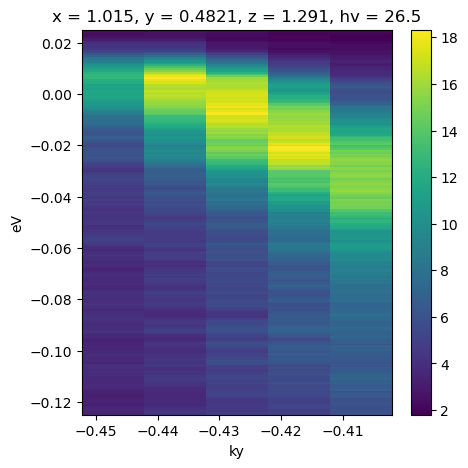

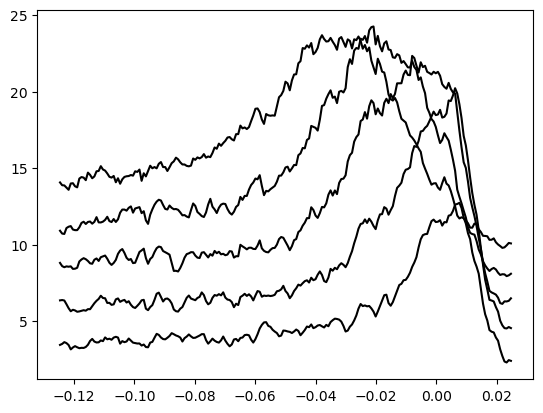

In [15]:

node_horiz = scan.sel(kx=slice(-0.01, 0.01 ), ky=slice(-0.45,-0.4), eV=slice(-0.125, 0.025)).sum("kx")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

node_horiz.plot(ax=ax)

plt.figure()

spacing = 2
for k, cut in enumerate(node_horiz.data.T):
    plt.plot(node_horiz['eV'], cut + spacing*k, color='k')


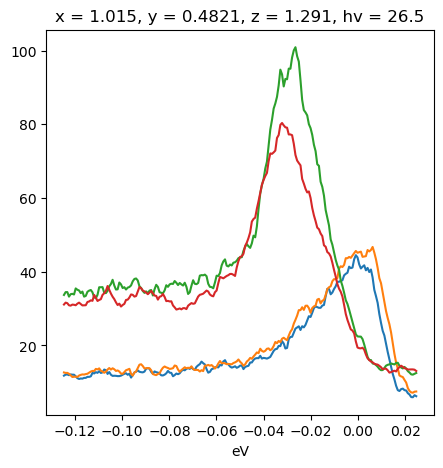

In [22]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
scan.sel(kx=slice(-0.01, 0.01 ), ky=slice(0.42,0.45), eV=slice(-0.125, 0.025)).sum("kx").sum("ky").plot(ax = ax)
scan.sel(kx=slice(-0.01, 0.01 ), ky=slice(-0.45,-0.42), eV=slice(-0.125, 0.025)).sum("kx").sum("ky").plot(ax = ax)

scan.sel(kx=slice(0.56, 0.58 ), ky=slice(0.45,0.5), eV=slice(-0.125, 0.025)).sum("kx").sum("ky").plot(ax = ax)
scan.sel(ky=slice(0.56, 0.58 ), kx=slice(0.45,0.5), eV=slice(-0.125, 0.025)).sum("kx").sum("ky").plot(ax = ax)


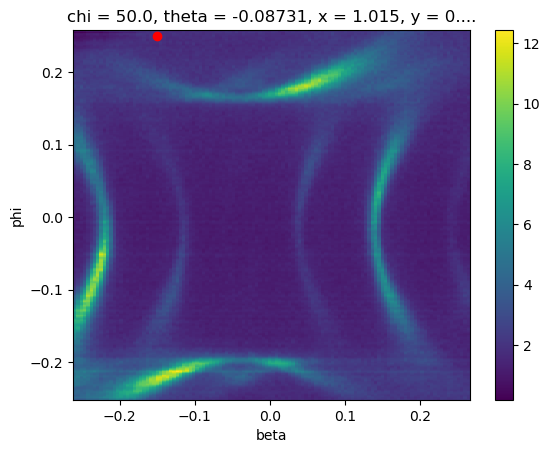

In [23]:
filtered_set.S.fermi_surface.S.plot()


# we will get the cut through these two points
# p1 = {
#     "phi": 0.25,
#     "beta": 0.1,
#     "eV": 0,
# }
# p2 = {
#     "phi": 0.12,
#     "beta": 0.22,
#     "eV": 0,
# }

p1 = {
    "phi": 0.25,
    "beta": -0.15,
    "eV": 0,
}
p2 = {
    "phi": 0.12,
    "beta": -0.27,
    "eV": 0,
}

plt.gca().scatter( p1['beta'], p1["phi"], color="red")
plt.gca().scatter( p2['beta'], p2["phi"], color="white")



{'kx': 0.6247221377656156, 'ky': -0.25498868281477005}
{'kx': 0.3165811965811964, 'ky': -0.5200337826424783}
[ 0.62472214 -0.25498868]
[ 0.3165812  -0.52003378]
-2.431239773189814
{'kx': -0.3068842268842271, 'ky': 0.5995824465389679} {'kx': 0.09930205060639838, 'ky': 0.5995824465389679}
0.0


(-0.15, 0.05)

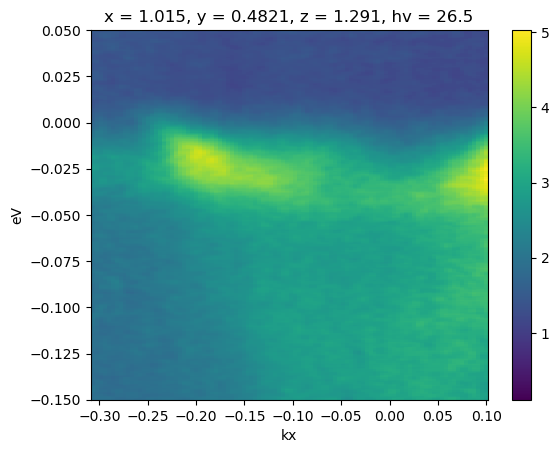

In [24]:
from arpes.analysis.moire import angle_between_vectors
from arpes.utilities.conversion.forward import convert_coordinate_forward, convert_through_angular_pair

kp1 = convert_coordinate_forward(filtered_set, p1)
kp2 = convert_coordinate_forward(filtered_set, p2)

def to_vec(p):
    return np.array([p["kx"], p["ky"]])

print(kp1)
print(kp2)
print(to_vec(kp1))
print(to_vec(kp2))
delta = to_vec(kp2) - to_vec(kp1)
ang = np.arctan2(delta[1], delta[0])
print(ang)

with filtered_set.S.with_rotation_offset(-ang):
    kp1 = convert_coordinate_forward(filtered_set, p1)
    kp2 = convert_coordinate_forward(filtered_set, p2)

    print(kp1, kp2)

    delta = to_vec(kp2) - to_vec(kp1)
    print(np.arctan2(delta[1], delta[0]))




plt.figure()

convert_through_angular_pair(
    filtered_set,
    p1, p2,
    {"kx": np.linspace(-0, 0, 100)}, # interpolate from p1 to p2 only
    {"ky": np.linspace(-0.2, 0.2, 100)}, # take 20 milli inv ang. perpendicular
).S.plot()

plt.ylim([-0.15, 0.05])
# plotted only for legibility


(-0.1, 0.05)

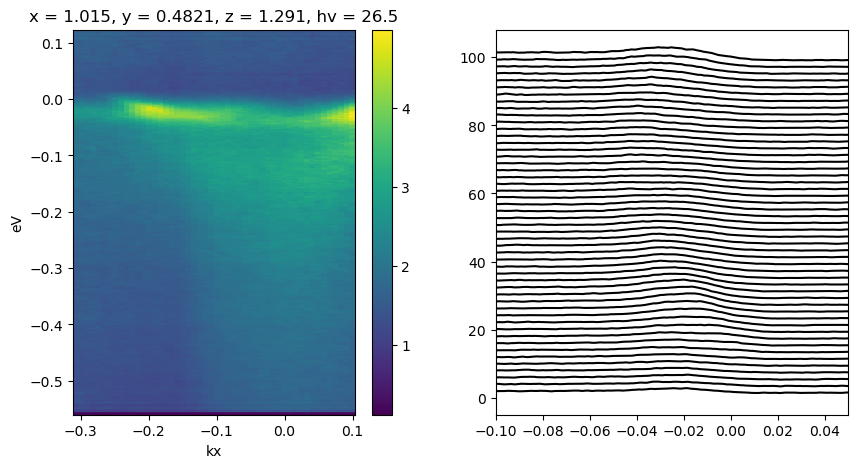

In [25]:
antinode = convert_through_angular_pair(
    filtered_set,
    p1, p2,
    {"kx": np.linspace(-0, 0, 50)}, # interpolate from p1 to p2 only
    {"ky": np.linspace(-0.2, 0.2, 50)}, # take 20 milli inv ang. perpendicular
)

fig = plt.figure(figsize = (10, 5))

ax1= plt.subplot(121)
antinode.plot(ax=ax1)

ax2 = plt.subplot(122)
spacing = 2
for k, cut in enumerate(antinode.data.T):
    plt.plot(antinode['eV'], cut + spacing*k, color='k')

plt.xlim(-.1, 0.05)




In [31]:
from arpes.fits.fit_models.functional_forms import twolorentzian, band_edge_bkg
from arpes.fits.fit_models import VoigtModel, TwoBandEdgeBModel

from lmfit import Model

# result = 
# result.plot()
# params = model_fit.make_params()
results = broadcast_model(TwoBandEdgeBModel, antinode.sel(kx = slice(-0.2, -0.1), eV = slice(-0.5, 0.1)), "kx")  
#results.F.show()


# ax.scatter(*results.F.p("fd_center").G.to_arrays(), color="red")
# ax.axhline(y=0, color='k', linestyle='--', linewidth=1)

# data_gold[temperature]['fit_Fermi'] = lin_mod

# plt.show()



Fitting:   0%|          | 0/12 [00:00<?, ?it/s]

<xarray.DataArray (kx: 12)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * kx       (kx) float64 -0.1991 -0.1908 -0.1825 ... -0.1245 -0.1162 -0.1079
    x        float64 1.015
    y        float64 0.4821
    z        float64 1.291
    hv       float64 26.5

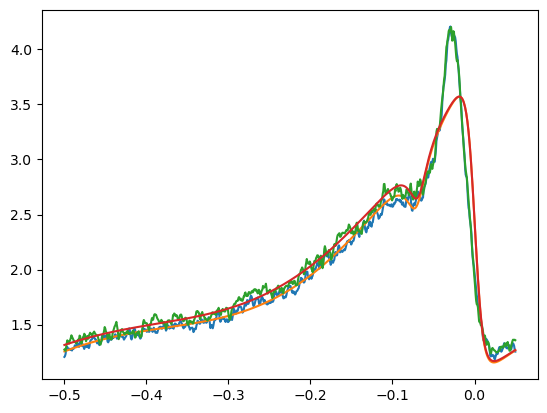

In [82]:
from arpes.fits.fit_models.functional_forms import twolorentzian, band_edge_bkg, lorentzian, gaussian

twoLor = Model(band_edge_bkg) + Model(gaussian, prefix = 'inc_')
data2fit = antinode.sel(kx = slice(-0.15, -0.14), eV = slice(-0.5, 0.05))
params = twoLor.make_params()

for key in params.keys():
    params[key].value = 0.0

params['center'].value = 0; params['center'].vary = False 
params['width'].value = 0.005; params['width'].vary = False 
params['amplitude'].value = 2
params['gamma'].value = 0.01
params['lor_center'].value = -0.05
params['const_bkg'] .value = 1
params['offset'] .value = 1
params['lin_bkg'] .value = 0.2
params['inc_center'] .value = -0.2
params['inc_sigma'] .value = 0.1
params['inc_amplitude'] .value = 0.2

# params['const_bkg'].value = 1
# params['amp'].value = 4 
# params['center'].value = -.05
# params['gamma'].value = .01
# params['t_amp'].value = 2
# params['t_center'].value = -.1
# params['t_gamma'].value = .1

for E_cuts in data2fit.data.T:

    res = twoLor.fit(E_cuts, x= data2fit['eV'], params=params)
    plt.plot(data2fit['eV'], E_cuts)
    plt.plot(data2fit['eV'], res.best_fit)

    

In [77]:
print(res.fit_report())

[[Model]]
    (Model(band_edge_bkg) + Model(gaussian, prefix='inc_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 112
    # data points      = 843
    # variables        = 9
    chi-square         = 12.2808517
    reduced chi-square = 0.01472524
    Akaike info crit   = -3546.98435
    Bayesian info crit = -3504.35164
    R-squared          = 0.96583432
##  Warning: uncertainties could not be estimated:
[[Variables]]
    center:         0 (fixed)
    width:          0.01 (fixed)
    amplitude:      0.09197183 (init = 2)
    gamma:          0.03138666 (init = 0.01)
    lor_center:    -0.02681829 (init = -0.05)
    offset:         1.27107832 (init = 1)
    lin_bkg:        2.94268810 (init = 0.2)
    const_bkg:      1.32468550 (init = 1)
    inc_center:     0.00000000 (init = 0)
    inc_sigma:      0.00000000 (init = 0)
    inc_amplitude:  0.00000000 (init = 0)
